* Ở phần này, nhóm sẽ thực hiện phân tích dựa trên dữ liệu sân bay Hoa Kỳ.
* Nhóm sẽ thực hiện phân tích các chuyến bay và xem xét sự chậm trễ của các hãng hàng không.
* Bây giờ, nhóm sẽ thực hiện phân tích các chuyến bay. 

In [1]:
from graphframes.lib import AggregateMessages as AM
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark import SparkContext
from graphframes import *
from operator import itemgetter
import matplotlib.pyplot as plt
import networkx as nx
import findspark
import pandas as pd
from bokeh.plotting import *
import csv

findspark.init()

In [2]:
def plotGraph(url, name):
    from bokeh.sampledata import us_states
    us_states = us_states.data.copy()

    del us_states["HI"]
    del us_states["AK"]

    # đọc vĩ độ và kinh độ của Hoa Kỳ vào mảng
    state_xs = [us_states[code]["lons"] for code in us_states]
    state_ys = [us_states[code]["lats"] for code in us_states]

    # khởi tạo đối tượng figure
    p = figure(title="US Airports",
            toolbar_location="left", plot_width=1100, plot_height=700)

    # vẽ vĩ độ và kinh độ lên figure
    p.patches(state_xs, state_ys, fill_alpha=0.0, line_color="#884444", line_width=1.5)

    x = []
    y =[]
    
    # load các điểm sân bay vào mảng
    with open(url, "r") as latlongs_file:
        reader = csv.reader(latlongs_file, delimiter=",")
        for row in reader:
            x.append(float(row[3]))
            y.append(float(row[2]))

    # vẽ các scatter figure
    p.circle(x, y, size=6, color='navy', alpha=1)

    # export ra file csv
    output_file(name + ".html")

    # hiển thị kết quả
    show(p)

In [3]:
spark = SparkSession.builder.appName("PageRank").getOrCreate()
sc = spark.sparkContext

22/01/23 08:42:23 WARN Utils: Your hostname, Rose resolves to a loopback address: 127.0.1.1; using 192.168.1.14 instead (on interface enp3s0)
22/01/23 08:42:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/01/23 08:42:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


* Trước tiên, ta sẽ đọc tập dữ liệu chứa các thông tin về sân bay.
* Ta sẽ chỉ lấy các thông tin về:
  * `name`: tên sân bay.
  * `id`: mã sân bay.
  * `latitude`: vĩ độ.
  * `longitude`: kinh độ.

In [4]:
nodes = spark.read.csv("data/airports.csv", header=False)

* Tiến hành đặt lại tên các cột và lọc, ở đây ta chỉ quan tâm các chuyến bay của quốc gia **United States**.

In [5]:
cleaned_nodes = (nodes.select("_c1", "_c3", "_c4", "_c6", "_c7")
                 .filter("_c3 = 'United States'")
                 .withColumnRenamed("_c1", "name")
                 .withColumnRenamed("_c4", "id")
                 .withColumnRenamed("_c6", "latitude")
                 .withColumnRenamed("_c7", "longitude")
                 .drop("_c3"))
cleaned_nodes = cleaned_nodes[cleaned_nodes["id"] != "\\N"]


cleaned_nodes.show()

+--------------------+---+------------------+-------------------+
|                name| id|          latitude|          longitude|
+--------------------+---+------------------+-------------------+
|Barter Island LRR...|BTI|     70.1340026855|     -143.582000732|
|Cape Lisburne LRR...|LUR|       68.87509918|       -166.1100006|
|Point Lay LRRS Ai...|PIZ|       69.73290253|       -163.0050049|
|Hilo Internationa...|ITO|19.721399307250977|-155.04800415039062|
|Orlando Executive...|ORL|   28.545499801636|   -81.332901000977|
|     Bettles Airport|BTT|       66.91390228|        -151.529007|
|       Clear Airport|Z84|         64.301201|        -149.119995|
|Indian Mountain L...|UTO|       65.99279785|       -153.7039948|
|  Fort Yukon Airport|FYU| 66.57150268554688|            -145.25|
|Sparrevohn LRRS A...|SVW|       61.09740067|       -155.5740051|
|Bryant Army Heliport|FRN|       61.26639938|       -149.6529999|
|Tatalina LRRS Air...|TLJ|62.894401550299996|     -155.977005005|
|Cape Roma

* Tiếp theo, ta sẽ đọc tập dữ liệu chứa thông tin về các chuyến bay.

In [6]:
relationships = spark.read.csv("data/188591317_T_ONTIME.csv", header=True)

In [7]:
cleaned_relationships = (relationships
                         .select("ORIGIN", "DEST", "FL_DATE", "DEP_DELAY",
                                 "ARR_DELAY", "DISTANCE", "TAIL_NUM", "FL_NUM",
                                 "CRS_DEP_TIME", "CRS_ARR_TIME", "UNIQUE_CARRIER")
                         .withColumnRenamed("ORIGIN", "src")
                         .withColumnRenamed("DEST", "dst")
                         .withColumnRenamed("DEP_DELAY", "deptDelay")
                         .withColumnRenamed("ARR_DELAY", "arrDelay")
                         .withColumnRenamed("TAIL_NUM", "tailNumber")
                         .withColumnRenamed("FL_NUM", "flightNumber")
                         .withColumnRenamed("FL_DATE", "date")
                         .withColumnRenamed("CRS_DEP_TIME", "time")
                         .withColumnRenamed("CRS_ARR_TIME", "arrivalTime")
                         .withColumnRenamed("DISTANCE", "distance")
                         .withColumnRenamed("UNIQUE_CARRIER", "airline")
                         .withColumn("deptDelay", F.col("deptDelay").cast(FloatType()))
                         .withColumn("arrDelay", F.col("arrDelay").cast(FloatType()))
                         .withColumn("time", F.col("time").cast(IntegerType()))
                         .withColumn("arrivalTime", F.col("arrivalTime").cast(IntegerType())))

cleaned_relationships.show()

22/01/23 08:42:31 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+---+----------+---------+--------+--------+----------+------------+----+-----------+-------+
|src|dst|      date|deptDelay|arrDelay|distance|tailNumber|flightNumber|time|arrivalTime|airline|
+---+---+----------+---------+--------+--------+----------+------------+----+-----------+-------+
|ATL|SLC|2018-05-01|     -1.0|    -3.0| 1590.00|     N6709|          15|1920|       2120|     DL|
|LAS|DTW|2018-05-01|      7.0|    -2.0| 1749.00|    N820DN|          16|1400|       2102|     DL|
|DTW|LAS|2018-05-01|     -4.0|    23.0| 1749.00|    N856DN|          17|1757|       1915|     DL|
|MSP|DTW|2018-05-01|     -6.0|   -13.0|  528.00|    N329NB|          22|1335|       1615|     DL|
|DTW|MSP|2018-05-01|      6.0|     6.0|  528.00|    N697DL|          23|1556|       1650|     DL|
|SAN|ATL|2018-05-01|     -2.0|   -18.0| 1892.00|    N323DN|          30| 745|       1458|     DL|
|ATL|DFW|2018-05-01|     -3.0|    -6.0|  731.00|    N901DE|          31|1938|       2102|     DL|
|DFW|ATL|2018-05-01|

> Nhận xét:
> * Sẽ có một vài trường dữ liệu mà ta cần quan tâm là như sau:
>   * `src`: mã sân bay xuất phát.
>   * `dst`: mã sân bay đến.
>   * `deptDelay`: còn gọi là **departure delay**, thời gian delay ở sân bay khởi hành.
>   * `arrDelay`: còn gọi là **arrival delay**, thời gian delay ở sân bay đến.
>   * `airline`: mã chuyến bay, vì giữa hai sân bay sẽ có thể có nhiều hãng hàng thông vận tải trên chuyến bay đó hoặc chuyến bay này phục vụ cho các mục đích khác nhau, nên ta cần mã này.

* Bây giờ, ta tạo `GraphFrame` từ tập dữ liệu chứa các thông tin về sân bay và chuyến bay lần lượt từ `@cleaned_nodes` và `@cleaned_relationships`.

In [8]:
g = GraphFrame(cleaned_nodes, cleaned_relationships)

* Tiếp theo, nhóm tải tập dữ liệu chứa thông tin các **hãng hàng không** cùng **id** tương ứng của hãng đó.

In [9]:
airlines_reference = (spark.read.csv("data/airlines.csv").select("_c1", "_c3")
                                .withColumnRenamed("_c1", "name")
                                .withColumnRenamed("_c3", "code"))
airlines_reference = airlines_reference[airlines_reference["code"] != "null"]

airlines_reference.show()

+--------------------+----+
|                name|code|
+--------------------+----+
|             Unknown|   -|
|      Private flight|   -|
|       1Time Airline|  1T|
|         40-Mile Air|  Q5|
|    Ansett Australia|  AN|
|Abacus International|  1B|
|     Abelag Aviation|  W9|
|          Aigle Azur|  ZI|
|      Aloha Airlines|  AQ|
|   American Airlines|  AA|
|     Asiana Airlines|  OZ|
|     Askari Aviation|  4K|
|   Afriqiyah Airways|  8U|
|Afrinat Internati...|  Q9|
|       Allegiant Air|  G4|
|            Aban Air|  K5|
|ABSA - Aerolinhas...|  M3|
|          Antrak Air|  04|
|    Airborne Express|  GB|
|             ABX Air|  GB|
+--------------------+----+
only showing top 20 rows



* Tiếp theo, nhóm có thể tìm hiểu sơ bộ về tập dữ liệu này qua biến `@g`, ta có thể biết là Hoa Kỳ có tổng cộng bao nhiêu sân bay vào thời điểm tháng 5 năm 2018.

In [10]:
g.vertices.count()

1333

> Nhận xét:
> * Ở thởi điểm tháng 5 năm 2018, ở Hoa Kỳ có khoảng 1333 sân bay.

* Mã dưới đây, nhóm tiến hành thông kê xem có bao nhiêu đường bay nối giữa các sân bay.

In [11]:
g.edges.count()

616529

> Nhận xét:
> * Vào thời điểm tháng 5 năm 2018, Hoa Kỳ có khoảng 616529 đường bay đang (hoặc tạm dừng) hoạt động.

* Tiếp theo, nhóm cũng muốn biết là "sân bay nào có nhiều chuyến bay xuất phát nhất". Đây chính là lúc ta sử dụng thuật toán **Degree Centrality**.
* Mã dưới đây giúp ta tính toán số bậc ngoài (tức số chuyến bay xuất phát) của từng sân bay.

In [12]:
airports_degree = g.outDegrees.withColumnRenamed("id", "oId")

In [13]:
airports_degree.show(10)

+---+---------+
|oId|outDegree|
+---+---------+
|BGM|       88|
|PSE|       62|
|INL|       51|
|MSY|     4957|
|PPG|        9|
|GEG|     1066|
|SNA|     3565|
|BUR|     2298|
|GRB|      431|
|GTF|      136|
+---+---------+
only showing top 10 rows



In [14]:
full_airports_degree = (airports_degree
                        .join(g.vertices, airports_degree.oId == g.vertices.id)
                        .sort("outDegree", ascending=False)
                        .select("id", "name", "outDegree"))

full_airports_degree.show(n=10, truncate=False)

+---+------------------------------------------------+---------+
|id |name                                            |outDegree|
+---+------------------------------------------------+---------+
|ATL|Hartsfield Jackson Atlanta International Airport|33837    |
|ORD|Chicago O'Hare International Airport            |28338    |
|DFW|Dallas Fort Worth International Airport         |23765    |
|CLT|Charlotte Douglas International Airport         |20251    |
|DEN|Denver International Airport                    |19836    |
|LAX|Los Angeles International Airport               |19059    |
|PHX|Phoenix Sky Harbor International Airport        |15103    |
|SFO|San Francisco International Airport             |14934    |
|LGA|La Guardia Airport                              |14709    |
|IAH|George Bush Intercontinental Houston Airport    |14407    |
+---+------------------------------------------------+---------+
only showing top 10 rows



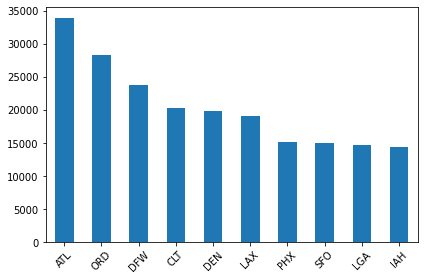

In [15]:
ax = (full_airports_degree
      .toPandas()
      .head(10)
      .plot(kind='bar', x='id', y='outDegree', legend=None))

ax.xaxis.set_label_text("")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

> Nhận xét:
> * Bên trên là 10 hãng hàng không mà có số chuyên bay xuất phát nhiều nhất vào thời điểm tháng 5 năm 2018 tại Hoa Kỳ.
> * Các sân bay như CLT, DEN,... có số lượng chuyển bay giảm **đột ngột** so với sân bay ALT.

* Nhóm cũng có thể xem các chuyến bay xuất phát từ sân bay **ORD** và bị delay, được nhóm theo sân bay đến.
* Nhóm tính thời gian delay trung bình trên cột `averageDelay` (tính theo phút).
* Thời gian delay trung bình trên được tính dựa trên `numberOfDelays`, `numberOfDelays` là số chuyến bay bị delay.

In [16]:
delayed_flights = (g.edges.filter("src = 'ORD' and deptDelay > 0")
                   .groupBy("dst")
                   .agg(F.avg("deptDelay"), F.count("deptDelay"))
                   .withColumn("averageDelay", F.round(F.col("avg(deptDelay)"), 2))
                   .withColumn("numberOfDelays", F.col("count(deptDelay)")))

(delayed_flights.join(g.vertices, delayed_flights.dst == g.vertices.id)
    .sort(F.desc("averageDelay"))
    .select("dst", "name", "averageDelay", "numberOfDelays")
    .show(n=10, truncate=False))

+---+-------------------------------------------+------------+--------------+
|dst|name                                       |averageDelay|numberOfDelays|
+---+-------------------------------------------+------------+--------------+
|CKB|North Central West Virginia Airport        |145.08      |12            |
|OGG|Kahului Airport                            |119.67      |9             |
|MQT|Sawyer International Airport               |114.75      |12            |
|MOB|Mobile Regional Airport                    |102.2       |10            |
|TTN|Trenton Mercer Airport                     |101.18      |17            |
|AVL|Asheville Regional Airport                 |98.5        |28            |
|ISP|Long Island Mac Arthur Airport             |94.08       |13            |
|ANC|Ted Stevens Anchorage International Airport|83.74       |23            |
|BTV|Burlington International Airport           |83.2        |25            |
|CMX|Houghton County Memorial Airport           |79.18       |17

> Nhận xét:
> * Có đến hơn 2 tiếng delay trung bình cho các chuyến bay xuất phát từ sân bay **ORD** đến **CKB**, ta có thể lợi dụng thuật toán **BFS** của Spark để xem các số liệu từ đó suy ra điều gì xảy ra với các chuyến bay này.

* Ở đây, nhóm xem xét các chuyến bay xuất phát từ sân bay **ORD** đến sân bay **CKB**.
* Thuật toán **BFS** nằm trong các thuất toán build-in methods được hỗ trợ bởi Spark.

In [17]:
from_expr = 'id = "ORD"'
to_expr = 'id = "CKB"'
ord_to_ckb = g.bfs(from_expr, to_expr)

ord_to_ckb = ord_to_ckb.select(F.col("e0.date"),
                               F.col("e0.time"),
                               F.col("e0.flightNumber"),
                               F.col("e0.deptDelay"))

ord_to_ckb.show()

+----------+----+------------+---------+
|      date|time|flightNumber|deptDelay|
+----------+----+------------+---------+
|2018-05-01|1645|        5066|     43.0|
|2018-05-02|1645|        5066|    881.0|
|2018-05-03|1645|        5066|     -6.0|
|2018-05-16|1645|        5066|     20.0|
|2018-05-17|1645|        5066|     -6.0|
|2018-05-18|1645|        5066|     30.0|
|2018-05-27|1645|        5066|     -4.0|
|2018-05-28|1645|        5066|     48.0|
|2018-05-29|1645|        5066|     -1.0|
|2018-05-30|1645|        5066|    237.0|
|2018-05-04|1645|        5066|      0.0|
|2018-05-05|1645|        5066|    -10.0|
|2018-05-06|1645|        5066|     -7.0|
|2018-05-07|1645|        5066|     -8.0|
|2018-05-23|1645|        5066|     -3.0|
|2018-05-24|1645|        5066|    -11.0|
|2018-05-25|1645|        5066|      0.0|
|2018-05-26|1645|        5066|     -5.0|
|2018-05-08|1645|        5066|     -4.0|
|2018-05-09|1645|        5066|     -4.0|
+----------+----+------------+---------+
only showing top

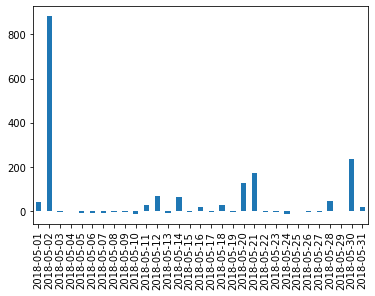

In [18]:
ax = (ord_to_ckb.sort("date")
      .toPandas()
      .plot(kind='bar', x='date', y='deptDelay', legend=None))

ax.xaxis.set_label_text("")
plt.show()

> Nhận xét:
> * Ở đây, ta thấy có chuyến bay vào ngày 02/05/2018 xuất phát trễ đến 14 tiếng so với dự kiến.
> * Có đến gần một nữa số chuyến bat từ **ORD** đến **CKB** mà bị delay so với dự kiến.
> * Lí giải cho sự chậm trễ này trong ngành hàng không thì rất có thể do vấn đề về thời tiết.

* Tiếp theo, nhóm sẽ tìm các chuyến bay bị delay khi xuất phát hoặc hạ cánh tại sân bay **SFO**. Giả sử bạn bay từ Việt Nam sang Ba Lan thì bạn bắt buộc phải hạ cánh ở sân bay Singapore để máy bay nạp nhiên liệu rồi mới bay tiếp (hãng hàng không Vietnam Airline).
* Các chuyến bay mà nhóm quan tâm:
  *  Được xuất phát hoặc hạ cánh từ sân bay **SFO**.
  *  Chỉ tính các chuyến bay trong ngày 11/05/2018.
  *  Thời gian delay khi xuất phát tại sân bay **SFO** phải hơn 30 phút.
  *  Thời gian delay khi hạ canh tại sân bay **SFO** phải hơn 30 phút.
* Để làm được các truy vấn bao gồm nhiều điều kiện như vậy, Spark-DataFrame hỗ trợ cơ chế tìm kiếm theo [**motif**](https://graphframes.github.io/graphframes/docs/_site/user-guide.html#motif-finding).
* Dưới đây là mã cho mục đích trên.

In [19]:
motifs = (g.find("(a)-[ab]->(b); (b)-[bc]->(c)")
          .filter("""(b.id = 'SFO') and
                     (ab.date = '2018-05-11' and bc.date = '2018-05-11') and
                     (ab.arrDelay > 30 or bc.deptDelay > 30) and
                     (ab.flightNumber = bc.flightNumber) and
                     (ab.airline = bc.airline) and
                     (ab.time < bc.time)"""))

result = (motifs.withColumn("delta", motifs.bc.deptDelay - motifs.ab.arrDelay)
                .select("ab", "bc", "delta")
                .sort("delta", ascending=False))

In [20]:
result.select(F.col("ab.src").alias("a1"),
              F.col("ab.time").alias("a1DeptTime"),
              F.col("ab.arrDelay"),
              F.col("ab.dst").alias("a2"),
              F.col("bc.time").alias("a2DeptTime"),
              F.col("bc.deptDelay"),
              F.col("bc.dst").alias("a3"),
              F.col("ab.airline"),
              F.col("ab.flightNumber"),
              F.col("delta")).show()

+---+----------+--------+---+----------+---------+---+-------+------------+-----+
| a1|a1DeptTime|arrDelay| a2|a2DeptTime|deptDelay| a3|airline|flightNumber|delta|
+---+----------+--------+---+----------+---------+---+-------+------------+-----+
|PDX|      1130|   -18.0|SFO|      1350|    178.0|BUR|     WN|        1454|196.0|
|ACV|      1755|    -9.0|SFO|      2235|     64.0|RDM|     OO|        5700| 73.0|
|BWI|       700|    -3.0|SFO|      1125|     49.0|IAD|     UA|         753| 52.0|
|ATL|       740|    40.0|SFO|      1110|     77.0|SAN|     UA|        1900| 37.0|
|BUR|      1405|    25.0|SFO|      1600|     39.0|PDX|     WN|         157| 14.0|
|DTW|       835|    34.0|SFO|      1135|     44.0|DTW|     DL|         745| 10.0|
|DEN|      1830|    25.0|SFO|      2045|     33.0|BUR|     WN|        1783|  8.0|
|PDX|      1855|   119.0|SFO|      2120|    117.0|DEN|     WN|        5789| -2.0|
|BUR|      2025|    31.0|SFO|      2230|     11.0|PHX|     WN|        1585|-20.0|
+---+----------+

> Nhận xét:
> * Bảng trên thể hiện các chuyên bay đi từ sân bay `@a1` đến sân bay `@a3` và dừng chân giữa chừng tại sân bay **SFO** (tức `@a2`).
> * Ở đây, ta hãy nhìn vào dòng đầu tiên, chuyên bay có mã **WN** - chuyến bay này xuất phát từ sân bay **PDX** và hạ cánh lần đầu ở sân bay **SFO** sớm hơn dự kiến 18 phút nhưng lại khởi hành tới sân bay đích là **BUR** trễ đến 3 tiếng.

* Tiếp theo, nhóm sẽ tiến hành đếm số chuyến bay mà mỗi hãng hàng không đang kinh doanh.

In [21]:
airlines = (g.edges
            .groupBy("airline")
            .agg(F.count("airline").alias("flights"))
            .sort("flights", ascending=False))

full_name_airlines = (airlines
                      .join(airlines_reference, airlines.airline == airlines_reference.code)
                      .select("code", "name", "flights")
                      .sort("flights", ascending=False))

full_name_airlines.show(truncate=False)

+----+---------------------------+-------+
|code|name                       |flights|
+----+---------------------------+-------+
|WN  |Southwest Airlines         |116849 |
|DL  |Delta Air Lines            |81735  |
|AA  |American Airlines          |77957  |
|OO  |SkyWest                    |65157  |
|UA  |United Airlines            |52816  |
|YX  |Midwest Airlines           |27398  |
|B6  |JetBlue Airways            |26513  |
|MQ  |American Eagle Airlines    |25364  |
|OH  |Comair                     |23869  |
|AS  |Alaska Airlines            |22974  |
|9E  |Pinnacle Airlines          |21097  |
|YV  |Mesa Airlines              |17866  |
|EV  |Atlantic Southeast Airlines|16661  |
|NK  |Spirit Airlines            |14889  |
|F9  |Frontier Airlines          |10297  |
|G4  |Allegiant Air              |8033   |
|HA  |Hawaiian Airlines          |7054   |
+----+---------------------------+-------+



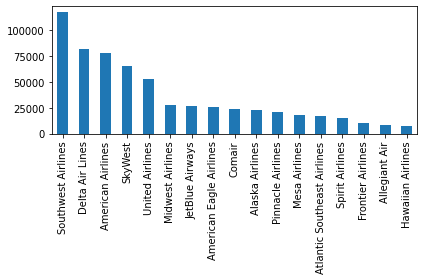

In [22]:
ax = (full_name_airlines.toPandas()
      .plot(kind='bar', x='name', y='flights', legend=None))

ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()

> Nhận xét:
> * Ta thấy rằng hãng hàng không **Southwest Airlines** là một **ông lớn** đúng nghĩa của Hoa Kỳ vào năm 2018 với chỉ trong tháng 5 mà họ có đến hơn 100000 ngàn chuyến bay. Như vậy trung bình 1 ngày họ có đến hơn 3333 ngàn chuyến bay.
> * Còn đây là số chuyến bay trong 1 ngaỳ được nhóm tìm kiếm nhằm kiểm chứng lại (search vào ngày 15/01/2022)
>   ![](./images/01.png)

* Tiếp theo, ta dùng thuật toán **Strongly Connected Components** để tìm ra các sân bay mà họ **chơi thân** với nhau.
* Các sân bay **chơi thân** với nhau sẽ tạo thành một **nhóm các sân bay** mà mỗi sân bay trong nhóm này đều có ít nhất 1 đường đi đến các sân bay còn lại trong nhóm.

In [23]:
def find_scc_components(g, airline):
    # tạo ra một đồ thị con mà các chuyến bay được cung cấp bởi 
    # hãng bay @airline, sau đó tạo đồ thị mới
    airline_relationships = g.edges[g.edges.airline == airline]
    airline_graph = GraphFrame(g.vertices, airline_relationships)

    # tính toán Strongly Connected Components bằng Spark build-in method 
    scc = airline_graph.stronglyConnectedComponents(maxIter=10)

    # trả về số sân bay cung cấp các chuyến bay bay đến
    # sân bay @airline (được lưu vào `size`)
    return (scc
        .groupBy("component")
        .agg(F.count("id").alias("size"))
        .sort("size", ascending=False)
        .take(1)[0]["size"])

In [24]:
airline_scc = [(airline, find_scc_components(g, airline)) for airline in 
               airlines.toPandas()["airline"].tolist()]
airline_scc_df = spark.createDataFrame(airline_scc, ['id', 'sccCount'])

airline_reach = (airline_scc_df
                 .join(full_name_airlines, full_name_airlines.code == airline_scc_df.id)
                 .select("code", "name", "flights", "sccCount")
                 .sort("sccCount", ascending=False))

airline_reach.show(truncate=False)

22/01/23 08:43:18 WARN CacheManager: Asked to cache already cached data.        
22/01/23 08:43:30 WARN CacheManager: Asked to cache already cached data.        
22/01/23 08:43:40 WARN CacheManager: Asked to cache already cached data.        
22/01/23 08:43:50 WARN CacheManager: Asked to cache already cached data.        
22/01/23 08:43:54 WARN BlockManager: Block rdd_2150_6 already exists on this machine; not re-adding it
22/01/23 08:44:00 WARN CacheManager: Asked to cache already cached data.
22/01/23 08:44:09 WARN CacheManager: Asked to cache already cached data.        
22/01/23 08:44:18 WARN CacheManager: Asked to cache already cached data.        
22/01/23 08:44:27 WARN CacheManager: Asked to cache already cached data.        
22/01/23 08:44:34 WARN BlockManager: Block rdd_4266_5 already exists on this machine; not re-adding it
22/01/23 08:44:36 WARN CacheManager: Asked to cache already cached data.
22/01/23 08:44:45 WARN CacheManager: Asked to cache already cached data.        


+----+---------------------------+-------+--------+
|code|name                       |flights|sccCount|
+----+---------------------------+-------+--------+
|OO  |SkyWest                    |65157  |221     |
|DL  |Delta Air Lines            |81735  |142     |
|MQ  |American Eagle Airlines    |25364  |124     |
|G4  |Allegiant Air              |8033   |114     |
|EV  |Atlantic Southeast Airlines|16661  |102     |
|9E  |Pinnacle Airlines          |21097  |98      |
|UA  |United Airlines            |52816  |94      |
|OH  |Comair                     |23869  |93      |
|AA  |American Airlines          |77957  |91      |
|YV  |Mesa Airlines              |17866  |91      |
|WN  |Southwest Airlines         |116849 |85      |
|YX  |Midwest Airlines           |27398  |83      |
|F9  |Frontier Airlines          |10297  |76      |
|AS  |Alaska Airlines            |22974  |70      |
|B6  |JetBlue Airways            |26513  |64      |
|NK  |Spirit Airlines            |14889  |37      |
|HA  |Hawaii

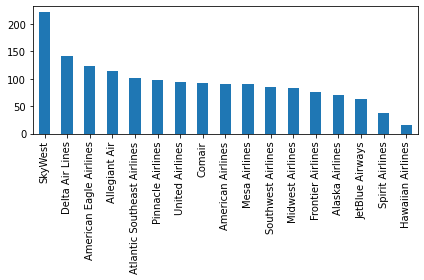

In [25]:
ax = (airline_reach.toPandas().plot(kind='bar', x='name', y='sccCount', legend=None))
ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()

> Nhận xét:
> * Sân bay **SkyWest** có đến hơn 200 đường bay được kết nối chặt chẽ đến các sân bay khác mặc dù cũng trong tháng 05/2018 họ chỉ kinh doanh hơn 65000 chuyến bay.
> * Ngược lại, **Southwest Airline** dù họ khai thác hơn 100000 chuyến bay chỉ trong tháng 5 nhưng họ chỉ có 85 sân bay khác là thân tín với họ.
> * Điều này có thể thể hiện được tư tưởng kinh doanh khác nhau giữa **SkyWest** khi họ thích kinh doanh và quan tâm với sự hợp tác với các đối tác khác còn **Southwest Airline** họ chú tâm hơn vào phát triển dịch vụ và số chuyến bay mà họ có thể khai thác được.

* Giả sử bây giờ, ta chỉ quan tâm vào các chuyến bay của hãng **DL**, và ta muốn biết xem họ thường phân bố các chuyến bay của họ như thế nào. Lúc này ta có thể sử dụng thuật toán LPA - một thuất toán học bán giám sát để làm điều này.
* Mã dưới đây, ta sẽ tạo ra một đồ thị mới mà chỉ chứa các chuyến bay của hãng **DL**. Sau đó tiến hành sử dụng LPA để tìm ra các nhóm (cộng đồng) dựa vào các chuyến bay (tức relationships) có chung đặc điểm.

In [26]:
airline_relationships = g.edges.filter("airline = 'DL'")
airline_graph = GraphFrame(g.vertices, airline_relationships)
clusters = airline_graph.labelPropagation(maxIter=10)

(clusters.sort("label")
        .groupby("label")
        .agg(F.collect_list("id").alias("airports"), F.count("id").alias("count"))
        .sort("count", ascending=False)
        .show(truncate=70, n=10))

22/01/23 08:45:51 WARN CacheManager: Asked to cache already cached data.
22/01/23 08:45:55 WARN BlockManager: Block rdd_8195_0 already exists on this machine; not re-adding it


+-------------+----------------------------------------------------------------------+-----+
|        label|                                                              airports|count|
+-------------+----------------------------------------------------------------------+-----+
|1606317768706|[IND, ORF, ATW, RIC, TRI, XNA, ECP, AVL, JAX, SYR, BHM, GSO, MEM, C...|   89|
|1219770712067|[GEG, SLC, DTW, LAS, SEA, BOS, MSN, SNA, JFK, TVC, LIH, JAC, FLL, M...|   53|
|  85899345921|                                                                 [EUG]|    1|
|  85899345923|                                                                 [RAL]|    1|
|  85899345922|                                                                 [PSG]|    1|
| 103079215110|                                                                 [SNP]|    1|
|  94489280512|                                                                 [ATY]|    1|
|  94489280513|                                                       

> Nhận xét:
> * Ta có thế thấy hầu hết các sân bay mà được hãng DL khai thác kinh doanh tập chung chủ yếu thành 2 nhóm.
> * Chúng ta sẽ trực quan hóa để xem các nhóm này có chung đặc điểm gì với nhau.

In [27]:
all_flights = g.degrees.withColumnRenamed("id", "aId")

* Mã dưới đây ta sẽ lọc các sân bay thuộc nhóm 1 (tức có label là **"1606317768706"** được Spark tự động khởi tạo khi chạy thuật toán LPA).

In [28]:
(clusters.filter("label=1606317768706")
            .join(all_flights, all_flights.aId == clusters.id)
            .sort("degree", ascending=False)
            .select("id", "name", "degree")
            .show(truncate=False))

+---+------------------------------------------------------------+------+
|id |name                                                        |degree|
+---+------------------------------------------------------------+------+
|DFW|Dallas Fort Worth International Airport                     |47514 |
|CLT|Charlotte Douglas International Airport                     |40495 |
|IAH|George Bush Intercontinental Houston Airport                |28814 |
|EWR|Newark Liberty International Airport                        |25131 |
|PHL|Philadelphia International Airport                          |20804 |
|BWI|Baltimore/Washington International Thurgood Marshall Airport|18989 |
|MDW|Chicago Midway International Airport                        |15178 |
|BNA|Nashville International Airport                             |12455 |
|DAL|Dallas Love Field                                           |12084 |
|IAD|Washington Dulles International Airport                     |11566 |
|STL|Lambert St Louis International Ai

* Trực quan hóa cho nhóm 1.

In [29]:
plotGraph("./data/latlongs-group1.csv", "group1")

![](./images/02.png)

> Nhận xét:
> * Ta thấy rằng, hãng **DL** tập trung khai thác các chuyến bay mà có sân bay khởi hành và sân bay đến nằm trong vùng phía đông của Hoa Kỳ, sau đó ít dần ở trung tâm Hoa Kỳ.

* Bây giờ ta sẽ xem xét các nhóm còn lại, tức nhóm 2.

In [30]:
(clusters.filter("label=1219770712067")
            .join(all_flights, all_flights.aId == clusters.id)
            .sort("degree", ascending=False)
            .select("id", "name", "degree")
            .show(truncate=False))

+---+----------------------------------------------------------+------+
|id |name                                                      |degree|
+---+----------------------------------------------------------+------+
|ATL|Hartsfield Jackson Atlanta International Airport          |67672 |
|ORD|Chicago O'Hare International Airport                      |56681 |
|DEN|Denver International Airport                              |39671 |
|LAX|Los Angeles International Airport                         |38116 |
|PHX|Phoenix Sky Harbor International Airport                  |30206 |
|SFO|San Francisco International Airport                       |29865 |
|LGA|La Guardia Airport                                        |29416 |
|LAS|McCarran International Airport                            |27801 |
|DTW|Detroit Metropolitan Wayne County Airport                 |27477 |
|MSP|Minneapolis-St Paul International/Wold-Chamberlain Airport|27163 |
|BOS|General Edward Lawrence Logan International Airport       |

* Trực quan hóa cho nhóm 2.

In [31]:
plotGraph("./data/latlongs-group2.csv", "group2")

![](./images/03.png)

> Nhận xét:
> * Ở nhóm thứ hai, ta thấy DL tập trung khai thác các sân bay nằm ở rìa bắc của Hoa Kỳ sau đó rãi rác dần xuống.
> * Ngoài ra, ta còn thấy các sân bay khác nằm ngoài lãnh thổ Hoa Kỳ, có khả năng các sân bay nằm ở phía nam Hoa Kỳ vẫn tồn tại là vì mục đích di chuyển đến các sân bay nằm ngoài Hoa Kỳ này.